# Simple implementation of ADMM to solve

$\min_x \|Ax-b\|^2 + \lambda\|x\|_1$

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import optlib.operators as op
import optlib.c_grad as cg
import importlib
%matplotlib qt

In [34]:
#Two new operators that we need
#These conform to our operator convention
#Each has a forward and a transpose

class ifft_op:
    """ Inverse fft operator. Takes a complex
        argument as input and produces a real
        output.
    """
    def __init__(self):
        pass
    def forward (self,x):
        return np.real(np.fft.ifftn(np.fft.ifftshift(x)))
    def transpose (self,x):
        return np.fft.fftshift(np.fft.fftn(np.real(x)))
    
class selection_op:
    """ Selection operator. Given a vector as an input it
        produces as an output certain components of the vector.
        See the __init__ and forward methods for details
    """
    def __init__(self,x_shape,idx):
        """ x_shape is the full shape of the input array for forward
            idx is the set of indices from which the components of 
                x are extracted to make the output 
            idx is required to be produced by np.r_ (see the use below)
            For now x is assumed to be 1-dimensional
        """
        self.x_shape=x_shape
        self.idx=idx
    def forward(self,x):
        return x[self.idx]
    def transpose(self,x):
        z=np.zeros(self.x_shape)
        z[idx]=x
        return z

In [26]:
# importlib.reload(cg) Uncomment this if you are changing the cg module to debug

def s_thresh(a,alpha):
    """ Soft thresholding needed for ADMM
    """
    return (np.maximum(abs(a),alpha)-alpha)*a/np.abs(a)
def norm(x):
    """ Returns the norm of x. Works for complex x
        Eventually to be replaced with the norm in 
            the cg module
    """
    return np.sqrt(np.sum(np.abs(x)**2))


def admm_l2_l1(A,b,x0,l1_wt=1.0,rho=1.0,iter_max=100,eps=1e-2):
    """ADMM L2 L1 function. Minimizes \|Ax-b\|^2 + \lambda \|x\|_1
       Input:
       A: operator, b as described in the formula above. x0 is the initial value of x
       l1_wt: This is lambda (I am not using lambda, because that is a protected
                                   word in Python)
       rho: Augmented Lagrangian parameter for ADMM
       iter_max: maximum number of iterations
       eps: stopping criterion (needs to be more sophisticated)
       
       Returns the minimizing x, and a flag indicated whether iter_max was reached
    """
    #Initialize variables
    xk=x0
    zk=np.zeros_like(x0)
    uk=np.zeros_like(x0)
    
    #initialize iteration
    B=op.scalar_prod_op(rho)
    mu=10
    rk_1=np.inf
    sk_1=np.inf
    steps=0

    #Iterate till termination
    while ((steps<iter_max)&((norm(rk_1)>eps)|(norm(sk_1)>eps))):
        xk_1,cg_flag=cg.solve_lin_cg(y,A,xk,B=B,c=rho*(zk-uk),max_iter=2,inner_max_iter=6)
        zk_1=s_thresh(xk_1+uk,l1_wt/rho)
        uk_1=uk+xk_1-zk_1
        rk_1=xk_1-zk_1
        sk_1= rho*(zk-zk_1)

    #Update variables
        xk=xk_1
        zk=zk_1
        uk=uk_1
        steps=steps+1
        
    #Update rho 
    #You may comment this out if you are adjusting rho manually
        if norm(rk_1)> mu*norm(sk_1):
            rho=rho*1.5
        elif norm(sk_1)> mu*norm(rk_1):
            rho=rho/1.5
               
    return xk,steps<iter_max

## Use case starts here

### Create data, add noise and sample

In [58]:
k=128
t=np.linspace(0,1,128)
x_true=np.sin(20*t+2.7)+0.2*np.cos(60*t)  #The true underlying signal
x_data=x_true+0.2*np.random.normal(size=t.size) #Data = true signal + noise
idx=np.r_[0:10,35:45,60:70,85:97,100:110]   #The components of x to be sampled
S=selection_op(x_true.shape,idx)            #Create the selection operator
y=S.forward(x_data)                         #Select the data
figure,ax=plt.subplots()
ax.plot(t,x_true,label='True signal')
ax.plot(t,x_data,label='Noisy Signal')
ax.plot(t,S.transpose(y),'r*',label='Sampled Data')
ax.legend(shadow=True)

In [50]:
F=ifft_op()
x_est=np.empty(128,dtype=complex)
x_est.real=0.0
x_est.imag=0.0

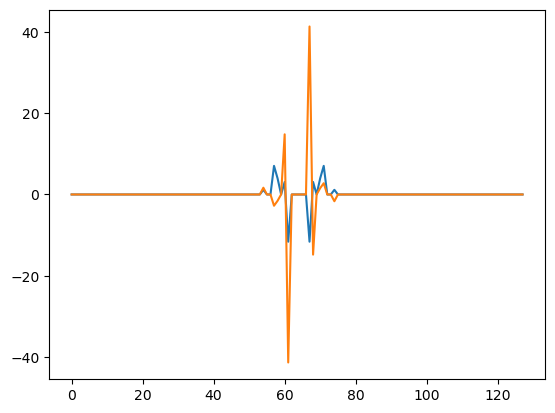

In [51]:
A=op.composite_op(S,F)
x_cg,_=admm_l1(A,y,x_est,l1_wt=4.0,rho=1.0,iter_max=100,eps=1e-2)
plt.plot(x_cg.real)
plt.plot(x_cg.imag)

In [60]:
y_est=F.forward(x_cg)
figure,ax=plt.subplots()
ax.plot(y_est, 'r-',label='Sig Est.')
ax.plot(x_true, 'b-',label='True Sig')
ax.legend(shadow=True)